# Deep Learning With Flux: Heart Segmentation Tutorial

## Download open source dataset

In [ ]:
!wget https://msd-for-monai.s3-us-west-2.amazonaws.com/Task02_Heart.tar

--2021-05-20 20:43:04--  https://msd-for-monai.s3-us-west-2.amazonaws.com/Task02_Heart.tar
Resolving msd-for-monai.s3-us-west-2.amazonaws.com (msd-for-monai.s3-us-west-2.amazonaws.com)... 52.218.132.121
Connecting to msd-for-monai.s3-us-west-2.amazonaws.com (msd-for-monai.s3-us-west-2.amazonaws.com)|52.218.132.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 455721472 (435M) [application/x-tar]
Saving to: ‘Task02_Heart.tar’

Task02_Heart.tar    100%[===================>] 434.61M  21.9MB/s    in 21s     

2021-05-20 20:43:26 (20.5 MB/s) - ‘Task02_Heart.tar’ saved [455721472/455721472]



## Julia on Colab Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.1" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia Tar MLDataPattern Glob NIfTI DLPipelines DataAugmentation Plots DataLoaders Random Flux FluxTraining ImageCore"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

Installing Julia 1.6.1 on the current Colab Runtime...
2021-05-20 20:43:31 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.6/julia-1.6.1-linux-x86_64.tar.gz [112784227/112784227] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package Tar...
Installing Julia package MLDataPattern...
Installing Julia package Glob...
Installing Julia package NIfTI...
Installing Julia package DLPipelines...
Installing Julia package DataAugmentation...
Installing Julia package Plots...
Installing Julia package DataLoaders...
Installing Julia package Random...
Installing Julia package Flux...
Installing Julia package FluxTraining...
Installing Julia package ImageCore...
Installing Julia package CUDA...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.6

Success! Please reload this page and jump to the next section.


## Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.6.1
Commit 6aaedecc44 (2021-04-23 05:59 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, haswell)
Environment:
  JULIA_NUM_THREADS = 2


## Import Packages

In [2]:
using Tar
using MLDataPattern
using Glob
using NIfTI
using DLPipelines
using DataAugmentation
using DataAugmentation: apply, RandomResizeCrop, CenterResizeCrop, ImageToTensor,
    NormalizeIntensity, OneHot, Image, itemdata, MaskMulti
using Plots
using DataLoaders
using Random
using Flux
using ImageCore

## Set up directory
* Publicly available for download though [Monai](https://docs.monai.io/en/latest/_modules/monai/data/dataset.html) or
* Publicly available for download through the original [Medical Decathlon Segmentation challenge](http://medicaldecathlon.com/)

In [26]:
tarball = "/content/Task02_Heart.tar"
directory = Tar.extract(tarball,"/content/heart2")

"/content/heart2"

In [27]:
data_dir = directory * "/Task02_Heart"

"/content/heart2/Task02_Heart"

In [28]:
struct imagesTr
	files::Vector{String}
end

struct labelsTr
	files::Vector{String}
end

In [29]:
MLDataPattern.nobs(ds::imagesTr) = length(ds.files)
MLDataPattern.getobs(ds::imagesTr, idx::Int) = NIfTI.niread(ds.files[idx]).raw
MLDataPattern.nobs(ds::labelsTr) = length(ds.files)
MLDataPattern.getobs(ds::labelsTr, idx::Int) = NIfTI.niread(ds.files[idx]).raw

In [30]:
train_images = imagesTr(Glob.glob("*.nii.gz", joinpath(data_dir, "imagesTr")))
train_labels = labelsTr(Glob.glob("*.nii.gz", joinpath(data_dir, "labelsTr")))
train_files, val_files = MLDataPattern.splitobs((train_images, train_labels), 0.8)

((DataSubset(::imagesTr, ::UnitRange{Int64}, ObsDim.Undefined())
 16 observations, DataSubset(::labelsTr, ::UnitRange{Int64}, ObsDim.Undefined())
 16 observations), (DataSubset(::imagesTr, ::UnitRange{Int64}, ObsDim.Undefined())
 4 observations, DataSubset(::labelsTr, ::UnitRange{Int64}, ObsDim.Undefined())
 4 observations))

Double check that the data files are set up properly. The files should contain multiple observations (images) and `MLDataPattern.getobs` should load the one or more files as pure Julia arrays

In [31]:
let
	x, y = MLDataPattern.getobs(train_files, 2)
	typeof(x), size(x), size(y)
end

(Array{Float32, 3}, (320, 320, 110), (320, 320, 110))

## Set up data loading pipelines
* Follow [this workflow](https://www.notion.so/Deep-learning-workflow-Ecosystem-overview-c5648bd1951b404d911fe705eced0e41) with some modifications

In [32]:
abstract type
	ImageSegmentationTask <: DLPipelines.LearningTask
end

In [33]:
struct ImageSegmentationSimple <: DLPipelines.LearningMethod{ImageSegmentationTask}
	imagesize
end

### Create `AddChannel()` transform
We are working with 3D grayscale images that need to be fed into a neural net as `size = (x, y, z, 1)`

In [34]:
struct MapItemData <: Transform
    f
end

In [35]:
DataAugmentation.apply(tfm::MapItemData, item::DataAugmentation.AbstractItem; randstate = nothing) = DataAugmentation.setdata(item, tfm.f(itemdata(item)))
DataAugmentation.apply(tfm::MapItemData, item::DataAugmentation.Image; randstate = nothing) = DataAugmentation.setdata(item, tfm.f(itemdata(item)))

In [36]:
AddChannel() = MapItemData(a -> reshape(a, size(a)..., 1))

AddChannel (generic function with 1 method)

In [37]:
imsize = (112, 112, 96)
method = ImageSegmentationSimple(imsize)

ImageSegmentationSimple((112, 112, 96))

### Set up `ecodeinput()` pipelines
Both the training set and the validation set require a pipeline. The validation set should not have any Random transforms whereas the training set can contain random transforms

In [38]:
function DLPipelines.encodeinput(
        method::ImageSegmentationSimple,
        context::Training,
        image)
    tfm = RandomResizeCrop(method.imagesize) |> ImageToTensor() |> NormalizeIntensity() |> AddChannel() 
    return apply(tfm, Image(ImageCore.colorview(Gray, image))) |> itemdata
end

function DLPipelines.encodeinput(
        method::ImageSegmentationSimple,
        context::Validation,
        image)
    tfm = CenterResizeCrop(method.imagesize) |> ImageToTensor() |> NormalizeIntensity() |> AddChannel() 
    return apply(tfm, Image(ImageCore.colorview(Gray, image))) |> itemdata
end

### Set up `ecodetarget()` pipelines
Both the training set and the validation set require a pipeline. The validation set should not have any Random transforms whereas the training set can contain random transforms

In [39]:
function DLPipelines.encodetarget(
        method::ImageSegmentationSimple,
        context::Training,
        image)
    tfm = RandomResizeCrop(method.imagesize) |> OneHot()
    return apply(tfm, MaskMulti(image .+ 1)) |> itemdata
end

function DLPipelines.encodetarget(
        method::ImageSegmentationSimple,
        context::Validation,
        image)
    tfm = CenterResizeCrop(method.imagesize) |> OneHot()
    return apply(tfm, MaskMulti(image .+ 1)) |> itemdata
end

### Set up dataset

In [40]:
methoddata_train = DLPipelines.MethodDataset(train_files, method, Training())
methoddata_valid = DLPipelines.MethodDataset(val_files, method, Validation())

DLPipelines.MethodDataset{ImageSegmentationSimple}
  data: Tuple{DataSubset{imagesTr, UnitRange{Int64}, LearnBase.ObsDim.Undefined}, DataSubset{labelsTr, UnitRange{Int64}, LearnBase.ObsDim.Undefined}}
  method: ImageSegmentationSimple
  context: Validation Validation()


Double check that the data processing works as expected. After applying the transforms, the first images `x, y` should now be of `size = (112, 112, 96, 1)`
*Note `imsize...` is the same as `(112, 112, 96)`*

In [41]:
let
	x, y = MLDataPattern.getobs(methoddata_train, 1)
	@assert size(x) == (imsize..., 1)
	@assert size(y) == (imsize..., 2)
end

In [42]:
let
	x, y = MLDataPattern.getobs(methoddata_train, 1)
	size(x)
end

(112, 112, 96, 1)

## Plot data

In [43]:
x, y = MLDataPattern.getobs(methoddata_valid, 2);

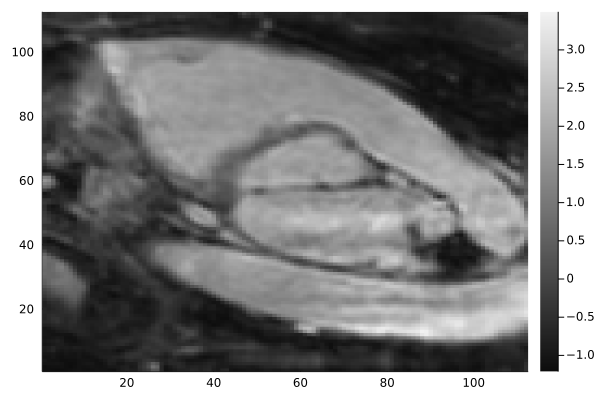

In [49]:
Plots.heatmap(x[:, :, 50, 1], c = :grays)

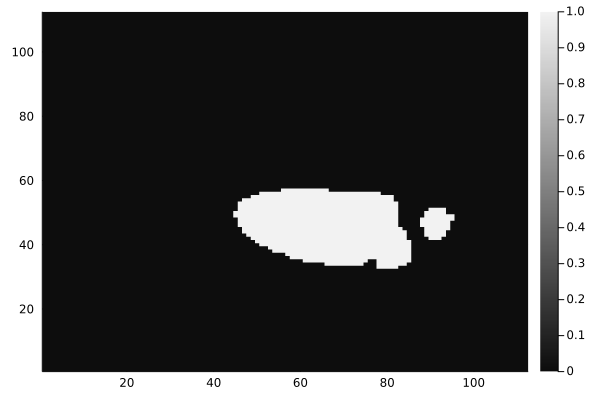

In [48]:
Plots.heatmap(y[:, :, 50, 2], c = :grays)

## Load data into a DataLoader
This allows us to iterate over batches of data easily

In [50]:
train_loader = DataLoaders.DataLoader(methoddata_train, 4)
val_loader = DataLoaders.DataLoader(methoddata_valid, 2)

eachobsparallel(batchviewcollated() with 2 batches of size 2)

Double check the size of the batches

In [51]:
for (xs, ys) in train_loader
	@assert size(xs) == (imsize..., 1, 4)
	@assert size(ys) == (imsize..., 2, 4)
end

## Set deterministic training for reproducibility

In [52]:
Random.seed!(1);

## Create model
* Create a [Unet model](https://arxiv.org/abs/1505.04597)
* Adapted from [link](https://github.com/DhairyaLGandhi/UNet.jl)
* Complete set of [medical specific deep learning models](https://github.com/Dale-Black/MedicalModels.jl)
*Note: this a 3-Dimensional UNet with residual `Parallel(+, ...)` connections*

In [53]:
# 3D layer utilities
conv = (stride, in, out) -> Conv((3, 3, 3), in=>out, stride=stride, pad=SamePad())
tran = (stride, in, out) -> ConvTranspose((3, 3, 3), in=>out, stride=stride, pad=SamePad())

conv1 = (in, out) -> Chain(conv(1, in, out), BatchNorm(out), x -> leakyrelu.(x))
conv2 = (in, out) -> Chain(conv(2, in, out), BatchNorm(out), x -> leakyrelu.(x))
tran2 = (in, out) -> Chain(tran(2, in, out), BatchNorm(out), x -> leakyrelu.(x))

#17 (generic function with 1 method)

In [54]:
function unet3D(in_chs, lbl_chs)
    # Contracting layers
    l1 = Chain(conv1(in_chs, 4))
    l2 = Chain(l1, conv1(4, 4), conv2(4, 16))
    l3 = Chain(l2, conv1(16, 16), conv2(16, 32))
    l4 = Chain(l3, conv1(32, 32), conv2(32, 64))
    l5 = Chain(l4, conv1(64, 64), conv2(64, 128))

    # Expanding layers
    l6 = Chain(l5, tran2(128, 64), conv1(64, 64))
    l7 = Chain(Parallel(+, l6, l4), tran2(64, 32), conv1(32, 32))
    l8 = Chain(Parallel(+, l7, l3), tran2(32, 16), conv1(16, 16))
    l9 = Chain(Parallel(+, l8, l2), tran2(16, 4), conv1(4, 4))
    l10 = Chain(l9, conv1(4, lbl_chs))
end

unet3D (generic function with 1 method)

## Train model

Here we will use the basics for training
* Dice loss
* ADAM optimizer
* etc

In [55]:
model = unet3D(1, 2)
ps = Flux.params(model)
loss_function = Flux.Losses.dice_coeff_loss
optimizer = Flux.ADAM(0.01)

ADAM(0.01, (0.9, 0.999), IdDict{Any, Any}())

In [1]:
max_epochs = 1
epoch_loss_values = []
metric_values = []

for epoch in 1:max_epochs
    epoch_loss = 0
    steps = 0
    
    # Loop through training data
    for (xs, ys) in train_loader
        steps += 1
        gs = Flux.gradient(ps) do
            ŷs = model(xs)
            loss = loss_function(ŷs[:, :, :, 2, :], ys[:, :, :, 2, :])
            epoch_loss += loss
            return loss
        end
        Flux.update!(optimizer, ps, gs)
    end
    
    epoch_loss = (epoch_loss / steps)
    push!(epoch_loss_values, epoch_loss)
end

LoadError: ignored

In [ ]:
epoch_loss_values